<font color='006A58'>**Graph Learning Tasks**</font>

One common problem data scientists face when dealing with networks is how to identify clusters and communities within a graph. This often arises when graphs are derived from social networks and communities are known to exist. However, the underlying algorithms and methods can also be used in other contexts, representing another option to perform clustering and segmentation. For example, these methods can effectively be used in text mining to identify emerging topics and to cluster documents that refer to single events/topics. A community detection task consists of partitioning a graph such that nodes belonging to the same community are tightly connected with each other and are weakly connected with nodes from other communities.

In this notebook, we will explore some methods to perform a community detection using several algortihms.

In [ ]:
!pip install git+https://github.com/palash1992/GEM
!pip install communities

In [35]:
import numpy as np
import pandas as pd
import networkx as nx 
from sklearn.manifold import TSNE
from gem.embedding.hope import HOPE 
from matplotlib import pyplot as plt
from sklearn.decomposition import NMF
from sklearn.mixture import GaussianMixture
from communities.algorithms import girvan_newman
from communities.algorithms import louvain_method
from communities.algorithms import spectral_clustering

%matplotlib inline

In [3]:
import networkx as nx 
G = nx.barbell_graph(m1=10, m2=4)

### Matrix Factorization 

We start by using some matrix factorization technique to extract the embeddings, which are visualized and then clustered traditional clustering algorithms.  

In [4]:
gf = HOPE(d=4, beta=0.01) 
gf.learn_embedding(G) 
embeddings = gf.get_embedding()

SVD error (low rank): 0.052092


In [6]:
tsne = TSNE(n_components=2) 
emb2d = tsne.fit_transform(embeddings)

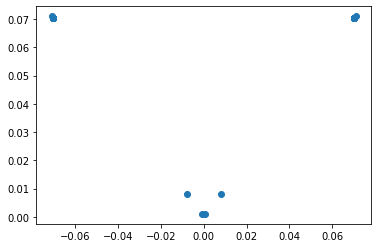

In [10]:
plt.plot(embeddings[:, 0], embeddings[:, 1], 'o', linewidth=0);

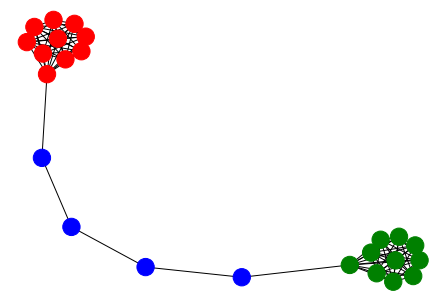

In [9]:
gm = GaussianMixture(n_components=3, random_state=0) #.(embeddings)
labels = gm.fit_predict(embeddings)
colors = ["blue", "green", "red"]
nx.draw_spring(G, node_color=[colors[label] for label in labels])

### Spectral Clustering

We now perform a spectral clustering based on the adjacency matrix of the graph. It is worth noting that this clustering is not a mutually exclusive clustering and nodes may belong to more than one community

In [12]:
adj = np.array(nx.adjacency_matrix(G).todense())

In [16]:
communities = spectral_clustering(adj, k=3)

In the next plot we highlight the nodes that belong to a community using the red color. The blue nodes do not belong to the given community

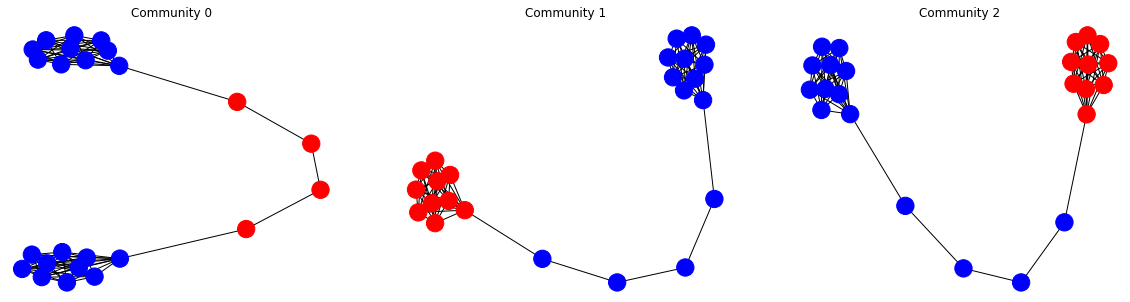

In [17]:
plt.figure(figsize=(20, 5))

for ith, community in enumerate(communities):
    cols = ["red" if node in community else "blue" for node in G.nodes]
    plt.subplot(1,3,ith+1)
    plt.title(f"Community {ith}")
    nx.draw_spring(G, node_color=cols)

The next command shows the node ids belonging to the different communities

In [18]:
communities

[{10, 11, 12, 13},
 {14, 15, 16, 17, 18, 19, 20, 21, 22, 23},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}]

### Non Negative Matrix Factorization 

Here, we again use matrix factorization, but now using the Non-Negative Matrix Factorization, and associating the clusters with the latent dimensions.

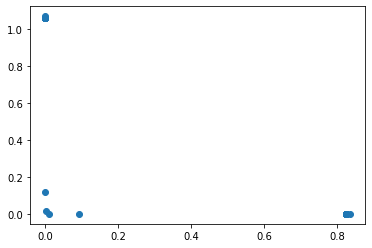

In [19]:
nmf = NMF(n_components=2)
emb = nmf.fit_transform(adj)
plt.plot(emb[:, 0], emb[:, 1], 'o', linewidth=0)

By setting a threshold value of 0.01, we determine which nodes belong to the given community.

In [20]:
communities = [set(np.where(emb[:,ith]>0.01)[0]) for ith in range(2)]

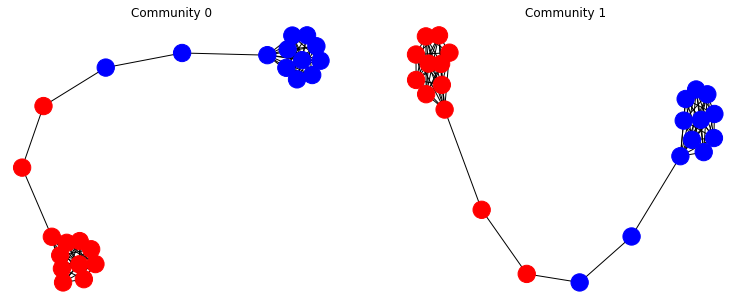

In [21]:
plt.figure(figsize=(20, 5))

for ith, community in enumerate(communities):
    cols = ["red" if node in community else "blue" for node in G.nodes]
    plt.subplot(1,3,ith+1)
    plt.title(f"Community {ith}")
    nx.draw_spring(G, node_color=cols)

Although the example above does not show this, in general also this clustering method may be non-mutually exclusive, and nodes may belong to more than one community

### Louvain and Modularity Optimization

Here, we use the Louvain method, which is one of the most popular methods for performing community detection, even on fairly large graphs. As described in the chapter, the Louvain method basically optimize the partitioning (it is a mutually exclusing community detection algorithm), identifying the one that maximize the modularity score, meaning that nodes belonging to the same community are very well connected among themself, and weakly connected to the other communities. 

**Louvain, unlike other community detection algorithms, does not require to specity the number of communities in advance and find the best, optimal number of communities.**

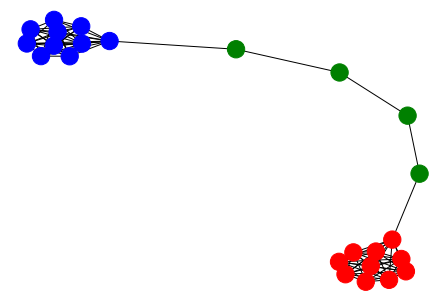

In [34]:
communities = louvain_method(adj)

c = pd.Series({node: colors[ith] for ith, nodes in enumerate(communities[0]) for node in nodes}).values
nx.draw_spring(G, node_color=c)

### Girvan Newman

The Girvan–Newman algorithm detects communities by progressively removing edges from the original graph. The algorithm removes the “most valuable” edge, traditionally the edge with the highest betweenness centrality, at each step. As the graph breaks down into pieces, the tightly knit community structure is exposed and the result can be depicted as a dendrogram.

**BE AWARE that because of the betweeness centrality computation, this method may not scale well on large graphs**

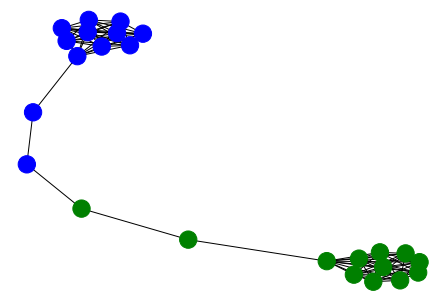

In [38]:
communities = girvan_newman(adj, n=2)
c = pd.Series({node: colors[ith] for ith, nodes in enumerate(communities[0]) for node in nodes}).values
nx.draw_spring(G, node_color=c)

In [41]:
communities[0]

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11},
 {12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}]